In [1]:
import numpy as np
import os
from sgimc.utils import make_imc_data, sparsify

from sgimc import IMCProblem

from sgimc.qa_objective import QAObjectiveL2Loss,\
                               QAObjectiveLogLoss
    
from sgimc.algorithm import admm_step
from sgimc.algorithm.decoupled import step as decoupled_step

from sgimc import imc_descent
from sgimc.utils import performance

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def step_qaadmm(problem, W, H, C, eta, method="l-bfgs", sparse=True,
                n_iterations=50, rtol=1e-5, atol=1e-8):

    approx_type = "quadratic" if method in ("cg",) else "linear"
    Obj = problem.objective(W, H, approx_type=approx_type)

    return admm_step(Obj, W, C, eta, sparse=sparse, method=method,
                     n_iterations=n_iterations, rtol=rtol, atol=atol)

def step_decoupled(problem, W, H, C, eta, rtol=1e-5, atol=1e-8):

    Obj = problem.objective(W, H, approx_type="linear")

    return decoupled_step(Obj, W, C, eta, rtol=rtol, atol=atol)

In [3]:
random_state = np.random.RandomState(0x0BADCAFE)

PROBLEM = "classification" if False else "regression"

step_fn = step_qaadmm

n_samples, n_objects = 199, 201
n_rank, n_features = 5, 20

In [4]:
X, W_ideal, Y, H_ideal, R_full = make_imc_data(
    n_samples, n_features, n_objects, n_features,
    n_rank, scale=(0.05, 0.05), noise=0,
    binarize=(PROBLEM == "classification"),
    random_state=random_state)

In [5]:
R, mask = sparsify(R_full, 0.10, random_state=random_state)

In [6]:
if PROBLEM == "classification":
    QAObjectiveLoss = QAObjectiveLogLoss
    C = 1e0, 1e-1, 1e-3
    eta = 1e0
else:
    QAObjectiveLoss = QAObjectiveL2Loss
    C = 2e-3, 2e-4, 1e-4
    eta = 1e1
    
problem = IMCProblem(QAObjectiveLoss, X, Y, R, n_threads=8)
    
if step_fn == step_decoupled:
    eta = 1e-3

In [7]:
from sgimc.utils import plot_WH, plot_loss

K = 10  # n_rank

W_0 = random_state.normal(size=(X.shape[1], K))
H_0 = random_state.normal(size=(Y.shape[1], K))

In [8]:
W, H = W_0.copy(), H_0.copy()

step_kwargs = {"C": C, "eta": eta, "rtol": 1e-5, "atol": 1e-8}

W, H = imc_descent(problem, W, H, step_fn, step_kwargs=step_kwargs,
                   n_iterations=1000, return_history=True,
                   rtol=1e-4, atol=1e-7, verbose=True)

  3%|▎         | 33/1000 [00:07<02:02,  7.90it/s]


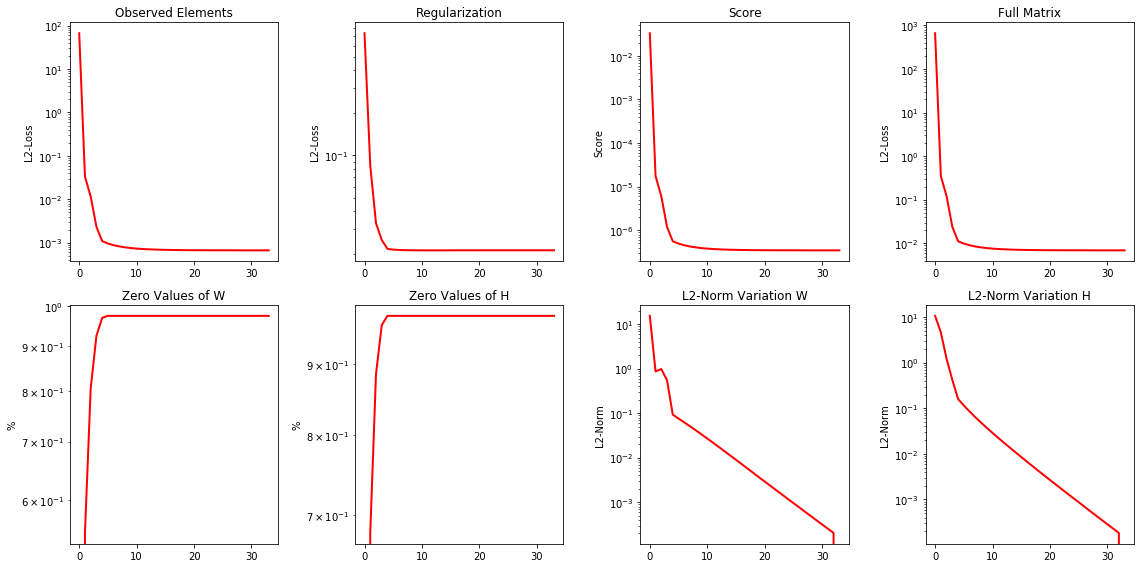

In [9]:
loss_arr, exp_type, norm_type = performance(problem, W, H, C, R_full)

plot_loss(loss_arr, exp_type, norm_type,
          fig_size=4, max_cols=4, yscale="log")

In [2]:
from build_experiment import build_experiment
from show_results import show_results

In [3]:
build_experiment('regression', 'qaadmm', [200, 300], [201, 301], [5,6], [15, 14], [10, 11],
                 0.1, (0.05, 0.05), 0, 0x0BADCAFE, '../data/')

  7%|▋         | 73/1000 [00:17<02:12,  6.97it/s]


In [4]:
import os
os.listdir('../data/')

['experiment_regres_qaadmm_20171120_195829',
 'keep_this_folder_empty',
 '.ipynb_checkpoints']

In [5]:
show_results('../data/experiment_regres_qaadmm_20171120_195829/')